# Weather prediction - time series
- Climate dataset from [ Max Planck Institute](https://www.bgc-jena.mpg.de/wetter/)
- Baseline from [keras](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)
- [Open in Colab](https://drive.google.com/file/d/15jaSG9xdD02dSPKs74LuQ-zmc68pV6-I/view?usp=sharing)

In [3]:
!pip install tfts
# !pip install -U git+https://github.com/LongxingTan/Time-series-prediction.git --quiet

ERROR: Could not find a version that satisfies the requirement tfts (from versions: none)
ERROR: No matching distribution found for tfts


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tfts import AutoConfig, AutoModel, KerasTrainer
import yfinance as yf

2025-04-09 10:06:18.615375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 10:06:18.669462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744218378.697884   41197 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744218378.705533   41197 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744218378.745777   41197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## EDA

In [9]:
'''
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = tf.keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

df.head()
'''
df = yf.download("AAPL", start="2010-01-01", end="2020-01-01")
df.head()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df['future_ret_1d'] = df['Close'].pct_change().shift(-1)
df['future_1d'] = df['Close'].shift(-1)


df.info()
df_original = df.copy()
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          2516 non-null   float64
 1   High           2516 non-null   float64
 2   Low            2516 non-null   float64
 3   Open           2516 non-null   float64
 4   Volume         2516 non-null   int64  
 5   future_ret_1d  2515 non-null   float64
 6   future_1d      2515 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.2 KB


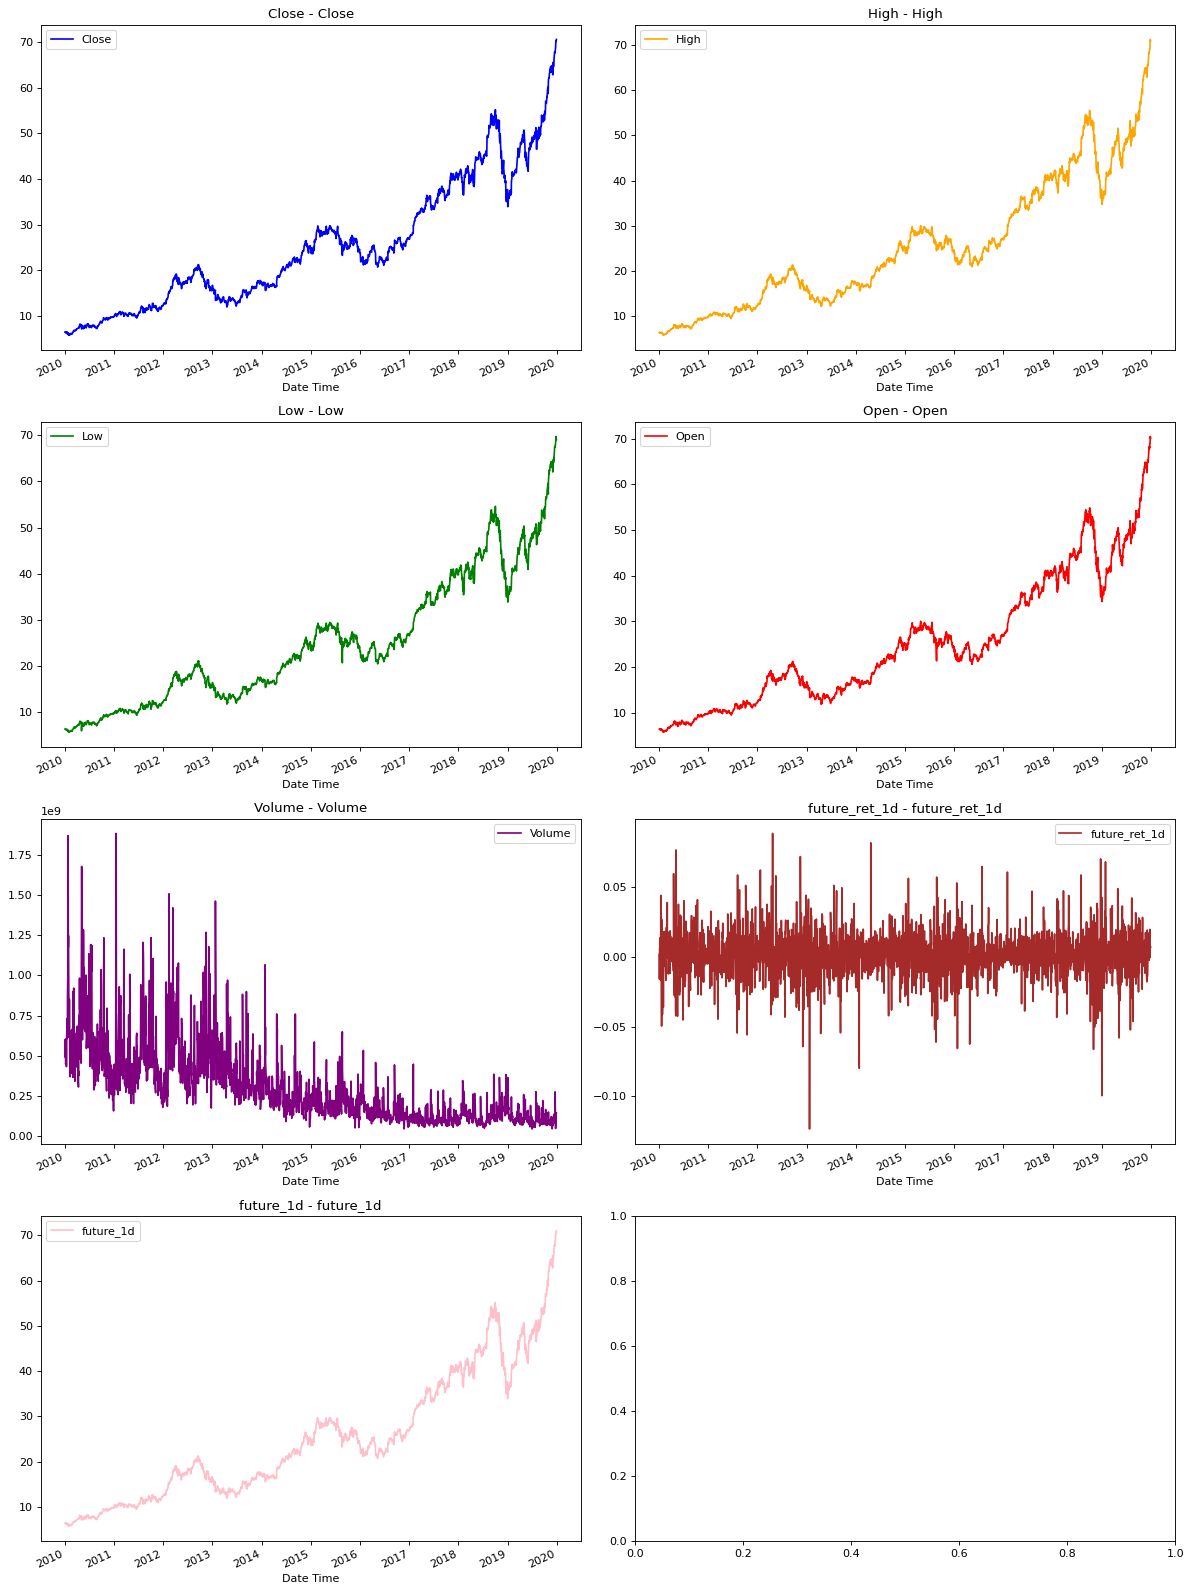

In [10]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
titles =df.columns.tolist()
feature_keys = df.columns.tolist()
df['Date'] =df.index

df = df.rename(columns={"Date": "Date Time"})

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Data preparation

In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 2, 3, 4, 6]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 2, 3, 4,6]]
print("The selected features are:", ", ".join(selected_features))
features = df[selected_features]
features.index = df[date_time_key]
features.head()
'''
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()
'''
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

start = past + future
end = start + train_split

x_train = train_data[[i for i in range(5)]].values
y_train = features.iloc[start:end][[5]]

print(x_train.shape)
print(y_train.shape)

print(x_train[:2])
print(y_train[:2])
sequence_length = int(past / step)


dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


# valid
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(5)]].values
y_val = features.iloc[label_start:][[5]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

The selected parameters are: Close, High, Low, Open, Volume, future_1d
The selected features are: Close, High, Low, Open, Volume, future_1d
(1798, 5)
(1723, 1)
[[-1.65573571 -1.66511304 -1.65074812 -1.65947686  0.5057168 ]
 [-1.65409167 -1.66030478 -1.64685308 -1.65427591  0.95421383]]
            5
792 -0.618263
793 -0.667522
Input shape: (256, 120, 5)
Target shape: (256, 1)


## Training

In [76]:
model_name_or_path = "rnn"
config = AutoConfig.for_model(model_name_or_path)
config.rnn_type = "lstm"
print(config)

model = AutoModel.from_config(config, predict_sequence_length=1)

{'rnn_hidden_size': 64, 'rnn_type': 'lstm', 'bi_direction': False, 'dense_hidden_size': 128, 'num_stacked_layers': 1, 'scheduled_sampling': 0.0, 'use_attention': False}


In [77]:
%%time
opt = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()
trainer = KerasTrainer(model, loss_fn=loss_fn, optimizer=opt)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

history = trainer.train(
    dataset_train, dataset_val, epochs=epochs, batch_size=batch_size, callbacks=[early_stop_callback]
)

Epoch 1/10
   1/1172 ━━━━━━━━━━━━━━━━━━━━ 3:17 168ms/step - loss: 5.9245

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(256, 120, 7))
  warnings.warn(msg)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2504

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(203, 120, 7))
  warnings.warn(msg)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 87s 74ms/step - loss: 0.2503 - val_loss: 0.1930
Epoch 2/10
   1/1172 ━━━━━━━━━━━━━━━━━━━━ 1:56 99ms/step - loss: 2.9296

/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(80, 120, 7))
  warnings.warn(msg)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 86s 74ms/step - loss: 0.1704 - val_loss: 0.1945
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 91s 77ms/step - loss: 0.1526 - val_loss: 0.1903
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 87s 74ms/step - loss: 0.1448 - val_loss: 0.1919
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - loss: 0.1424 - val_loss: 0.1825
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step - loss: 0.1354 - val_loss: 0.1776
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 85s 73ms/step - loss: 0.1285 - val_loss: 0.1678
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 84s 72ms/step - loss: 0.1249 - val_loss: 0.1679
Epoch 9/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - loss: 0.1214 - val_loss: 0.1582
Epoch 10/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - loss: 0.1224 - val_loss: 0.1559
CPU times: user 21min 18s, sys: 5min 33s, total: 26min 52s
Wall time: 14min 21s


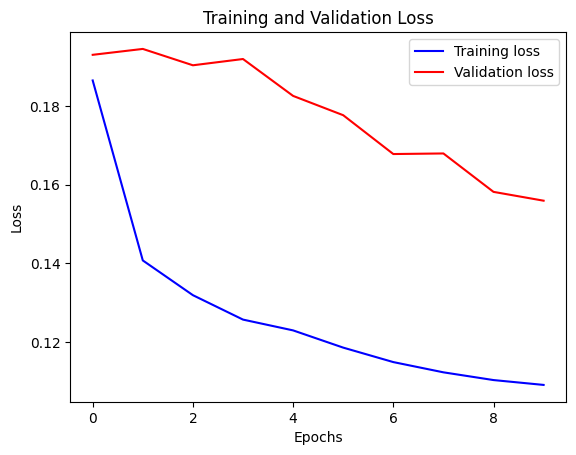

In [78]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Evaluation

## Testing

['__abstractmethods__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'build_model', 'config', 'from_config', 'from_pretrained', 'load_pretrained_weights', 'model', 'predict_sequence_length', 'save_model', 'save_pretrained', 'save_weights', 'summary', 'to_model']
(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))
(300693, 7)
(256, 120, 7)


/home/ming/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(1, 120, 7))
  warnings.warn(msg)


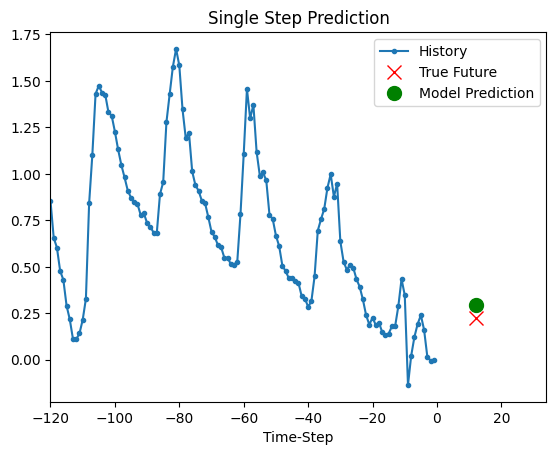

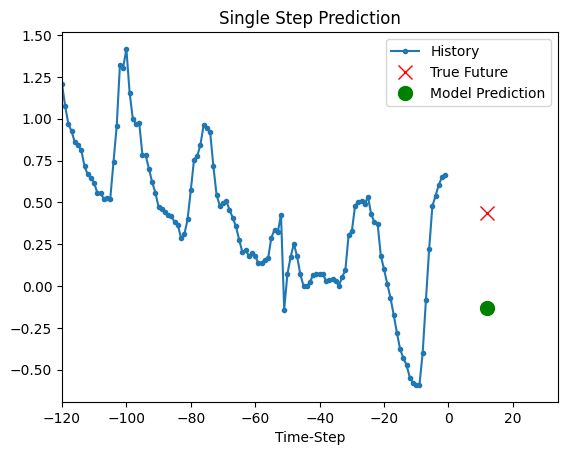

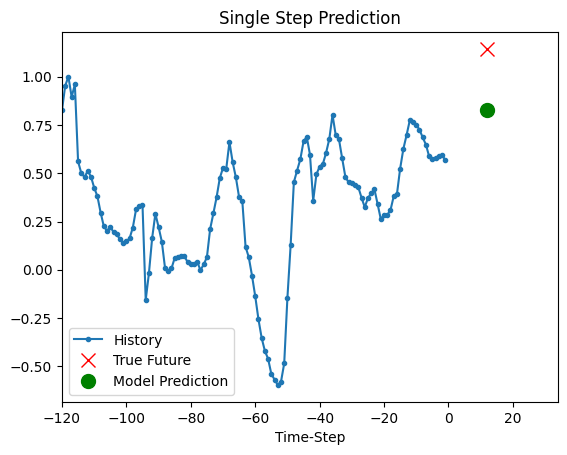

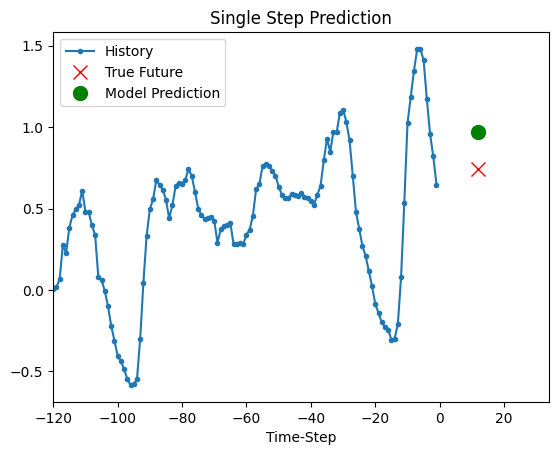

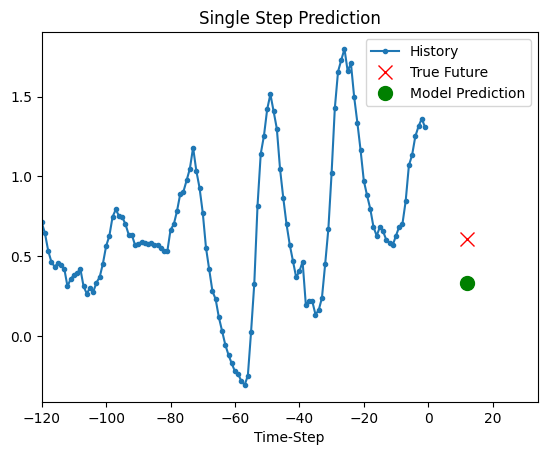

'\nfor x, y in dataset_val.take(5):\n    show_plot(\n        [x[0][:, 1].numpy(), y[0].numpy(), model(x)[0]],\n        12,\n        "Single Step Prediction",\n    )\n'

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.model(x[:1])[0]],
        12,
        "Single Step Prediction",
    )

